# Learning Disentangled Representations for Equivariant Inference: A Tutorial

In this notebook, we illustrate better the core ideas behind our paper while walking through a detailed synthetic experiment in the context of uncertainty quantification. We start by properly defining the terms we use.

**Invariance/Equivariance:** We use the same definitions as Geometric Deep Learning. Namely, $f$ is invariant (equivariant) if $f(x) = f(g\cdot x), \forall g \in \mathbb{G}$ ($g\cdot f(x) = f(g\cdot x)$). E.g., an image classifier should be invariant to translations, this is the main idea behind CNNs. What is peculiar to our work is that:
1. We consider finite symmetry groups, which could be discretized rotations or translations, or any other abstract symmetry group.
2. We go beyond just regression or classification, which learn the conditional mean $\mathbb{E}[Y \mid X = x]$, to learn the full conditional distribution $P_{Y\mid X = x}$. Also, note we don't require any new assumptions compared to Geometric Deep Learning, as augmentations and/or equivariance/invariance constraint already implicitely impose the symmetry priors we assume on eqs. 1(a-c).

**Equivariant Inference:** We take this to mean all problems that can be solved by learning the conditional distribution $P_{Y \mid X = x}$, including regressing equivariant functions, constructing confidence intervals, and estimating conditional densities $p_{Y\mid X}(y\mid x)$.

**Learning Representations:** This is where operators and functional analysis enter the picture. We build on ideas reminiscent from conditional mean embeddings literature to *represent* the conditional probability $P_{Y\mid X}$ as an operator (infinite-dimensional matrix) $\mathbb{E}_{Y\mid X}$. Then, following Kostic et al. (2024), we leverage the crucial fact that learning the truncated SVD of the conditional expectation operator w.r.t. Hilbert-Schmidt norm is equivalent to spectral contrastive learning, where instead of learning only representation for $x$, we learn for $x$ and $y$ at the same time. This connection is non-trivial and is precisely what enables us to give the statistical learning theory results.

**Learning Disentangled Representations:** Having reconciled operator theory and functional analysis with deep representation learning via spectral contrastive learning, we can now consider the symmetry priors and group representation theory. The key result here is Cartan's Theorem, which says that our symmetry priors (eqs. 1(a-c)) induce a decomposition of the function spaces where $\mathbb{E}_{Y\mid X}$ is defined. Namely, $\mathcal{L}^2_{P_X} = \sum^\perp_{k \in [1, n_\text{iso}]} \mathcal{L}_{P_X}^{2, (k)}$ (similarly for $\mathcal{L}_{P_Y}^2$). This decomposition breaks our infinite-dimensional feature spaces $\mathcal{L}^2_{P_X}$ and $\mathcal{L}^2_{P_Y}$ into subspaces which are $\mathbb{G}^{(k)}$-equivariant, showing a close connection to the concept of disentangled linear representations as defined by Higgins et al. (2018). This decomposition also reduces the problem to learning $n_\text{iso}$ smaller operators $\mathbb{E}_{Y\mid X}^{(k)}$, which we again do by putting ($\mathbb{G}$-equivariant) features on $x$ and $y$ and then performing spectral contrastive learning. The main methodological step we had to take is in how to juggle between isotypic and regular bases, which we solve in Section 4.2.

**Putting Everything Together:** Our method can be seen as spectral contrastive learning to learn embeddings $u$ and $v$ of $x$ and $y$ which turn nonlinear regression, uncertainty quantification, and conditional density estimation problems into linear problems on $u$ and $v$ (we will further illustrate this in the Camera Ready). Our key contribution compared to Kostic et al. (2024) lies in showing how to leverage common Geometric Deep Learning assumptions to make this approach more sample-efficient and generalizable when learning $\mathbb{G}$-equivariant (in a way, disentangled!) features.

# Dataset

**TODO:** Add LaTeX description of the data model. Discuss symmetries.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


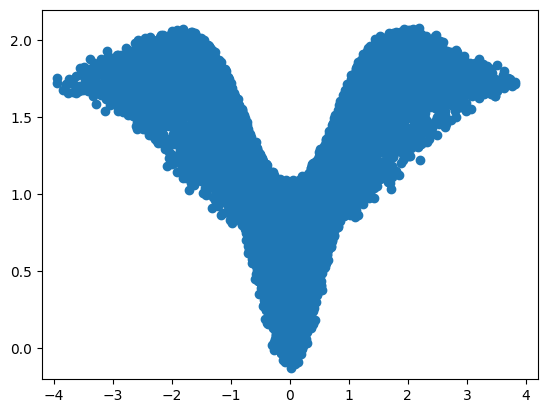

In [9]:
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2


def synthetic_dataset(n: int, p: int = 1, condition_on_x: torch.Tensor = None):
    """Synthetic dataset from https://arxiv.org/abs/2110.00816, Appendix B.1.

    Args:
        n: sample size
        p: number of features. Defaults to 1 (used in the paper).
        condition_on_x: If None, generates marginal model. If Tesor, expects shape (1, p).
    """
    beta_hat = torch.rand(size=(n, p))
    beta = beta_hat / torch.linalg.norm(beta_hat, ord=1, dim=1, keepdim=True)
    z = 2 * torch.pi * torch.rand(size=(n, p)) - torch.pi
    phi = 2 * torch.pi * torch.rand(size=(n, p))
    r = 2 * 0.1 * torch.rand(size=(n, p)) - 0.1
    if condition_on_x is None:
        x = (3.2 - 0.8) * torch.rand(size=(n, p)) + 0.8
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))
    else:
        x = condition_on_x
        y_0 = z / (beta * x).sum(dim=1, keepdim=True) + r * torch.cos(phi)
        y_1 = 0.5 * (-torch.cos(z) + 1) + r * torch.sin(phi) + torch.sin(x.mean(dim=1, keepdim=True))

    return x, y_0, y_1


# Plot marginal of Y = (Y_0, Y_1), Fig. 1 (left) of https://arxiv.org/abs/2110.00816
x, y_0, y_1 = synthetic_dataset(n=20000, p=1)
fig, ax = plt.subplots()
offset = 0.2
ax.set_xlim(-4 - offset, 4 + offset)
ax.set_ylim(0 - offset, 2 + offset)
ax.scatter(y_0, y_1)

### Plotting Conditional Distributions

x: 1.50
	Quantiles: Y_0 [-1.99, 1.99] Y_1 [0.97, 2.02]
	Empirical Coverage: 91.24% Set Size: 4.17
x: 2.00
	Quantiles: Y_0 [-1.49, 1.49] Y_1 [0.88, 1.93]
	Empirical Coverage: 91.11% Set Size: 3.13
x: 2.50
	Quantiles: Y_0 [-1.20, 1.20] Y_1 [0.57, 1.62]
	Empirical Coverage: 91.12% Set Size: 2.51
x: 2.00
	Quantiles: Y_0 [-1.49, 1.49] Y_1 [0.88, 1.93]
	Empirical Coverage: 91.11% Set Size: 3.13
x: 2.50
	Quantiles: Y_0 [-1.20, 1.20] Y_1 [0.57, 1.62]
	Empirical Coverage: 91.12% Set Size: 2.51


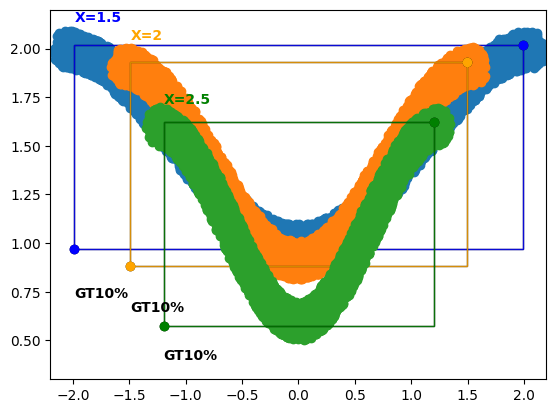

In [10]:
import numpy as np
from matplotlib.patches import Rectangle

ALPHA = 0.1


def plot_quantiles(
    low_q,
    up_q,
    y_c: torch.Tensor = None,
    alpha: float = 0.05,
    ax: plt.Axes = None,
    label: str = "pred",
    quantile_color: str = "red",
):
    """Plots the predicted quantiles against (empirical) ground truth quantiles.

    Args:
        low_q (np.ndarray): The lower quantiles predicted by the model.
        up_q (np.ndarray): The upper quantiles predicted by the model.
        y_c (torch.Tensor, optional): The data to compute the ground truth quantiles. Defaults to None.
        alpha (float, optional): Miscoverage level. Defaults to 0.05 for 95% coverage.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure and axis are created.
        label (str, optional): The label for the predicted quantiles. Defaults to "pred".
        quantile_color (str, optional): Color for confidence region. Defaults to "red".
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Add rectangle for the ground truth quantiles
    if y_c is not None:
        ax.scatter(y_c[:, 0], y_c[:, 1])
        low_q_gt, up_q_gt = np.quantile(y_c, alpha / 4, axis=0), np.quantile(y_c, 1 - (alpha / 4), axis=0)
        ax.scatter(low_q_gt[0], low_q_gt[1], color="black")
        ax.scatter(up_q_gt[0], up_q_gt[1], color="black")
        gt_rect = Rectangle(
            (low_q_gt[0], low_q_gt[1]),
            up_q_gt[0] - low_q_gt[0],
            up_q_gt[1] - low_q_gt[1],
            edgecolor="black",
            facecolor="none",
            alpha=0.8,
        )
        ax.add_patch(gt_rect)
        ax.text(
            low_q_gt[0],
            low_q_gt[1] * 0.8,
            f"GT{int(alpha * 100):d}%",
            color="black",
            verticalalignment="top",
            horizontalalignment="left",
            fontweight="bold",
        )

    # Add rectangle for the predicted quantiles
    ax.scatter(low_q[0], low_q[1], color=quantile_color)
    ax.scatter(up_q[0], up_q[1], color=quantile_color)
    pred_rect = Rectangle(
        (low_q[0], low_q[1]),
        up_q[0] - low_q[0],
        up_q[1] - low_q[1],
        edgecolor=quantile_color,
        facecolor="none",
        alpha=0.8,
    )
    ax.add_patch(pred_rect)
    ax.text(low_q[0], up_q[1] * 1.05, label, color=quantile_color, verticalalignment="bottom", fontweight="bold")

    return fig, ax


# Plot conditional of Y = (Y_0, Y_1) | X = [1.5, 2, 2.5] along with 90% confidence regions, Fig. 1 (right) of https://arxiv.org/abs/2110.00816
fig, ax = plt.subplots(ncols=1)
x = [1.5, 2, 2.5]
offset = 0.2
ax.set_xlim(-2 - offset, 2 + offset)
ax.set_ylim(0.5 - offset, 2 + offset)
for j, color in zip(range(3), ["blue", "orange", "green"]):
    # Plot conditional distribution
    _, y_0, y_1 = synthetic_dataset(n=20000, condition_on_x=torch.Tensor([x[j]]).reshape(-1, 1))

    # Plot confidence regions
    y_cond_x = np.hstack([y_0, y_1])
    low_q_gt, up_q_gt = np.quantile(y_cond_x, ALPHA / 4, axis=0), np.quantile(y_cond_x, 1 - (ALPHA / 4), axis=0)
    plot_quantiles(
        y_c=y_cond_x, low_q=low_q_gt, up_q=up_q_gt, alpha=ALPHA, ax=ax, label=f"X={x[j]}", quantile_color=color
    )
    coverage = (
        (low_q_gt <= y_cond_x).all(axis=1, keepdims=True) & (y_cond_x <= up_q_gt).all(axis=1, keepdims=True)
    ).mean()
    set_size = np.abs(up_q_gt - low_q_gt).prod()
    print(f"x: {x[j]:.2f}")
    print(f"\tQuantiles: Y_0 [{low_q_gt[0]:.2f}, {up_q_gt[0]:.2f}] Y_1 [{low_q_gt[1]:.2f}, {up_q_gt[1]:.2f}]")
    print(f"\tEmpirical Coverage: {coverage * 100:.2f}% Set Size: {set_size:.2f}")

# Our Approach Strikes a Balance Between Regression and Full Conditional Density Estimation

Having introduced our data model, we now highlight our method's main strength: unconditional training of conditional distributions. Typically in Machine Learning, one is interested in modeling the conditional behavior of $Y$ given $X=x$. This can be accomplished by performing either regression, quantile regression, or full conditional density estimation, each of which has its own set of limitations. E.g., in
1. Regression with supervised learning, one loses completely the aspect of uncertainty quantification;
2. Quantile regression with pinball loss, one has to retrain for each different choice of quantile $\alpha$; or
3. Conditional density estimation with normalizing flows, one pays a heavy computational price.

Our method is able to avoid the curse of dimensionality suffered by conditional density estimators by instead learning how to deform the marginal distribution $P_Y$ into the conditional $P_{Y\mid X=x}$ by learning features $u$ and $v$ of $x$ and $y$ such that $p_{Y\mid X}(y\mid x) = u(x)^TSv(y) p_Y(y)$, where $S$ is a learned matrix.

As NCP has already been extensively compared to normalizing flows and other CDE approaches in Kostic et al. (2024) and we have benchmarked symmetry-NCP on regression problems in robotics, in this notebook we focus on uncertainty quantification by showing how to extract the conditional CDF $F_{Y\mid X=x}(y) = P(Y \leq y \mid X = x)$ from our learned model and then how to generate confidence sets that contain $Y_\text{test}$ with high probability (chosen by the user).

### Experiment Config

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# CONFIG================================================================================================================
SAMPLE_SIZE = 20000  # (Table 4)
BATCH_SIZE = 1024  # (Appendix C)
EPOCHS = 500
DEVICE = "cuda:0"
# ======================================================================================================================

# GET DATA==============================================================================================================
x, y_0, y_1 = synthetic_dataset(n=SAMPLE_SIZE, p=1)
y = torch.hstack([y_0, y_1])

# Split dataset intro train, calibration, validation, and test
ntrain, ncal, nval, ntest = (
    int(0.384 * SAMPLE_SIZE),
    int(0.256 * SAMPLE_SIZE),
    int(0.16 * SAMPLE_SIZE),
    int(0.2 * SAMPLE_SIZE),
)
x_train, y_train = x[: ntrain + ncal, :], y[: ntrain + ncal, :]
x_train_mlp, y_train_mlp = x[:ntrain, :], y[:ntrain, :]
x_cal, y_cal = x[ntrain : ntrain + ncal, :], y[ntrain : ntrain + ncal, :]
x_val, y_val = x[ntrain + ncal : ntrain + ncal + nval, :], y[ntrain + ncal : ntrain + ncal + nval, :]
x_test, y_test = x[ntrain + ncal + nval :, :], y[ntrain + ncal + nval :, :]
print(f"Sanity check: train={x_train.shape[0]}, cal={x_cal.shape[0]}, val={x_val.shape[0]}, test={x_test.shape[0]}")

# Standardize datasets
x_train_mean = x_train.mean(dim=0)
y_train_mean = y_train.mean(dim=0)
x_train_std = x_train.std(dim=0)
y_train_std = y_train.std(dim=0)

x_train = (x_train - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
x_train_mlp = (x_train_mlp - x_train_mean) / x_train_std
y_train_mlp = (y_train_mlp - y_train_mean) / y_train_std

x_cal = (x_cal - x_train_mean) / x_train_std
y_cal = (y_cal - y_train_mean) / y_train_std

x_val = (x_val - x_train_mean) / x_train_std
y_val = (y_val - y_train_mean) / y_train_std

x_test = (x_test - x_train_mean) / x_train_std
y_test = (y_test - y_train_mean) / y_train_std

# Wrap tensors into Dataset and DataLoader
train_ds = TensorDataset(x_train, y_train)
train_mlp_ds = TensorDataset(x_train_mlp, y_train_mlp)
cal_ds = TensorDataset(x_cal, y_cal)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
train_dl_mlp = DataLoader(train_mlp_ds, shuffle=True, batch_size=BATCH_SIZE)
cal_dl = DataLoader(cal_ds, shuffle=False, batch_size=len(cal_ds))
val_dl = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

Sanity check: train=12800, cal=5120, val=3200, test=4000


### Training MLP

We start by training a neural network to predict the lower ($\alpha /4 $) and upper ($1-\alpha/4$) quantiles of $Y \mid X = x$, where $\alpha \in (0,1)$ is an user-specified level of coverage.

In [ ]:
import math

from torch.nn import BatchNorm1d, Linear, Sequential
from tqdm import tqdm


def pinball_loss(input: torch.Tensor, target: torch.Tensor, gamma: float):
    """Pinball loss of https://arxiv.org/pdf/2107.07511 (page 8) to learn (gamma/2)-quantiles.

    Args:
        input: Model output.
        target: Ground truth.
        gamma: Quantile to regress.

    """
    errors = target - input
    loss = torch.maximum(errors * gamma, -errors * (1 - gamma)).mean()
    return loss


def make_mlp(
    input_dim: int = 1,
    output_dim: int = 2,
    layer_size: int = 32,
    n_hidden: int = 2,
    activation: torch.nn.Module = torch.nn.ELU,
):
    layers = [Linear(input_dim, layer_size), activation(), BatchNorm1d(layer_size)]
    for _ in range(n_hidden - 1):
        layers += [Linear(layer_size, layer_size), activation(), BatchNorm1d(layer_size)]
    layers += [Linear(layer_size, output_dim), activation()]
    return Sequential(*layers)


# GET MODEL=============================================================================================================
lower_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)
upper_quantile_estimator = make_mlp(output_dim=2, layer_size=64, n_hidden=3).to(DEVICE)

# TRAIN MODEL===========================================================================================================
opt_lo = torch.optim.Adam(lower_quantile_estimator.parameters())
opt_up = torch.optim.Adam(upper_quantile_estimator.parameters())


def train(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    train_dl: DataLoader,
    opt_lo: torch.optim.Optimizer,
    opt_up: torch.optim.Optimizer,
):
    lo_q_est.train()
    up_q_est.train()
    for batch, (x, y) in enumerate(train_dl):
        x, y = x.to(DEVICE), y.to(DEVICE)
        q_lo, q_up = lo_q_est(x), up_q_est(x)

        loss_lo = pinball_loss(input=q_lo, target=y, gamma=ALPHA / 4)
        loss_up = pinball_loss(input=q_up, target=y, gamma=1 - ALPHA / 4)

        loss_lo.backward()
        loss_up.backward()

        opt_lo.step()
        opt_up.step()

        opt_lo.zero_grad()
        opt_up.zero_grad()


for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    # print(f"EPOCH: {epoch}")
    train(
        lo_q_est=lower_quantile_estimator,
        up_q_est=upper_quantile_estimator,
        train_dl=train_dl_mlp,
        opt_lo=opt_lo,
        opt_up=opt_up,
    )

    # if epoch % 25 == 0:
    # validate()

# CALIBRATION===========================================================================================================


def calibrate(
    lo_q_est: torch.nn.Module,
    up_q_est: torch.nn.Module,
    cal_ds: TensorDataset,
):
    lo_q_est.eval()
    up_q_est.eval()
    n_cal = len(cal_ds)
    adjusted_alpha = math.ceil((n_cal + 1) * (1 - ALPHA)) / n_cal

    with torch.no_grad():
        x, y = cal_ds.tensors
        x, y = x.to(DEVICE), y.to(DEVICE)

        q_lo, q_up = lo_q_est(x), up_q_est(x)

        nonconformity_scores = torch.maximum(q_lo - y, y - q_up).max(dim=1, keepdim=True)[0]

        q_hat = torch.quantile(nonconformity_scores, adjusted_alpha, interpolation="higher").item()

        return q_hat


q_hat_mlp = calibrate(lo_q_est=lower_quantile_estimator, up_q_est=upper_quantile_estimator, cal_ds=cal_ds)
print(f"Empirical Quantile Estimated with CP: {q_hat_mlp:.3f}")

Epochs:  89%|████████▉ | 888/1000 [00:38<00:05, 21.84it/s]

### Training NCP

In [ ]:
import importlib
import numpy as np

# Force reload of the updated modules
import symm_rep_learn.models.ncp
import symm_rep_learn.nn.layers
import symm_rep_learn.nn.losses
importlib.reload(symm_rep_learn.nn.losses)
importlib.reload(symm_rep_learn.models.ncp)
importlib.reload(symm_rep_learn.nn.layers)

from symm_rep_learn.models.ncp import NCP
from symm_rep_learn.nn.layers import MLP

embedding_dim = 16
ncp = NCP(
    embedding_x=MLP(input_shape=1, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU),
    embedding_y=MLP(input_shape=2, output_shape=embedding_dim, layer_size=64, n_hidden=3, activation=torch.nn.ELU),
    embedding_dim_x=embedding_dim,
    embedding_dim_y=embedding_dim,
    orth_reg=5,
).to(DEVICE)

lr = 5e-4
ncp_optimizer = torch.optim.Adam(ncp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)
# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")

relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_loss = np.infty
for epoch in pbar:
    ncp.train()
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        ncp_optimizer.zero_grad()
        fx, hy = ncp(x, y)
        loss, metrics = ncp.loss(fx, hy)

        loss.backward()
        ncp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_loss=val_loss, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        ncp.eval()
        with torch.no_grad():
            val_loss = 0

            for x, y in val_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                fx, hy = ncp(x, y)
                loss, metrics = ncp.loss(fx, hy)
                val_loss += loss.item()
                pbar.set_postfix(val_loss=loss)
            val_loss /= len(val_dl)

TypeError: NCP.__init__() got an unexpected keyword argument 'gamma'

### Training eNCP (Our Method)

In [ ]:
import numpy as np
from escnn.group import CyclicGroup
from escnn.gspaces import no_base_space
from escnn.nn import FieldType

from symm_rep_learn.models.equiv_ncp import ENCP
from symm_rep_learn.nn.equiv_layers import EMLP

G = CyclicGroup(2)
x_type = FieldType(no_base_space(G), representations=[G.representations["irrep_0"]])
# y0 transforms by reflections g. y0 = -y0
# y1 transforms by invariance  g. y1 = y1
y_type = FieldType(no_base_space(G), representations=[G.representations["irrep_1"], G.representations["irrep_0"]])
embedding_dim = 16
lat_type = FieldType(no_base_space(G), representations=[G.regular_representation] * int(embedding_dim // G.order()))

encp = ENCP(
    embedding_x=EMLP(in_type=x_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    embedding_y=EMLP(in_type=y_type, out_type=lat_type, hidden_units=64, hidden_layers=3, activation="ELU"),
    gamma=5,
).to(DEVICE)

lr = 5e-4
encp_optimizer = torch.optim.Adam(encp.parameters(), lr=lr)

CHECK_VAL_EVERY_N_EPOCHS = int(EPOCHS / 10)
# Initialize the progress bar
pbar = tqdm(range(EPOCHS), desc="Epochs")
relevant_metrics = ["tr(Cx)", "tr(Cy)", "||k(x,y) - k_r(x,y)||"]
val_loss = np.infty
for epoch in pbar:
    encp.train()
    for x, y in train_dl:
        x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
        encp_optimizer.zero_grad()
        fx, hy = encp(x, y)
        loss, metrics = encp.loss(fx, hy)

        loss.backward()
        encp_optimizer.step()

        # Update the progress bar with the loss
        pbar.set_postfix(
            loss=loss.item(), val_loss=val_loss, **{k: v for k, v in metrics.items() if k in relevant_metrics}
        )
    if epoch % CHECK_VAL_EVERY_N_EPOCHS == 0:
        encp.eval()
        with torch.no_grad():
            val_loss = 0

            for x, y in val_dl:
                x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
                fx, hy = encp(x, y)
                loss, metrics = encp.loss(fx, hy)
                val_loss += loss.item()
                pbar.set_postfix(val_loss=loss)
            val_loss /= len(val_dl)

# Comparison: CQR vs NCP vs eNCP

In [ ]:
import pandas as pd

from symm_rep_learn.inference.encp import ENCPConditionalCDF
from symm_rep_learn.inference.ncp import NCPConditionalCDF


def test_mlp_uq(lo_q_est: torch.nn.Module, up_q_est: torch.nn.Module, test_dl: DataLoader, q_hat: float):
    coverage = 0
    set_size = 0
    lo_q_est.eval()
    up_q_est.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Conformalize quantile estimates
            q_lo, q_up = lo_q_est(x) - q_hat, up_q_est(x) + q_hat

            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


def test_ncp_uq(model: NCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA / 2)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += ((q_lo <= y).all(dim=1, keepdim=True) & (y <= q_up).all(dim=1, keepdim=True)).type_as(y).mean()
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


def test_encp_uq(model: ENCPConditionalCDF, test_dl: DataLoader):
    coverage = 0
    set_size = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_dl):
            x, y = x_type(x).to(DEVICE), y_type(y).to(DEVICE)
            # Conformalize quantile estimates
            q_lo, q_up = model.conditional_quantiles(x_cond=x, alpha=ALPHA / 2)
            q_lo = torch.tensor(q_lo, device=DEVICE, dtype=torch.float32)
            q_up = torch.tensor(q_up, device=DEVICE, dtype=torch.float32)
            coverage += (
                ((q_lo <= y.tensor).all(dim=1, keepdim=True) & (y.tensor <= q_up).all(dim=1, keepdim=True))
                .type_as(y.tensor)
                .mean()
            )
            set_size += (q_up - q_lo).abs().prod(dim=1, keepdim=True).mean()
    coverage /= len(test_dl)
    set_size /= len(test_dl)

    return coverage, set_size


ncp_ccdf = NCPConditionalCDF(model=ncp, y_train=y_train, support_discretization_points=1000, lstsq=False)
encp_ccdf = ENCPConditionalCDF(model=encp, y_train=y_type(y_train), support_discretization_points=1000, lstsq=False)

coverage_mlp, set_size_mlp = test_mlp_uq(
    lo_q_est=lower_quantile_estimator,
    up_q_est=upper_quantile_estimator,
    test_dl=test_dl,
    q_hat=q_hat,  # q_hat_mlp
)
coverage_ncp, set_size_ncp = test_ncp_uq(model=ncp_ccdf, test_dl=test_dl)
coverage_encp, set_size_encp = test_encp_uq(model=encp_ccdf, test_dl=test_dl)


# Define the results
results = {
    "Model Type": ["NCP", "ENCP", "CQR"],
    "Coverage": [coverage_ncp.item() * 100, coverage_encp.item() * 100, coverage_mlp.item() * 100],
    "Set Size": [set_size_ncp.item(), set_size_encp.item(), set_size_mlp.item()],
}

# Create a DataFrame
df = pd.DataFrame(results)

# Format the float values to 3 decimal places
df["Coverage"] = df["Coverage"].map("{:.1f}%".format)
df["Set Size"] = df["Set Size"].map("{:.1f}".format)

# Display the DataFrame
print(df)